# Custom DFT for hi-res low-freqs spectrograms

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.figsize'] = [12, 12]

# Unoptimised spectrogram using `for` loop

In [70]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving malkauns.wav to malkauns.wav
User uploaded file "malkauns.wav" with length 352844 bytes


In [2]:
!ls

c-c#-192kHz (1).wav  c-c#-192kHz.wav  datalab  ff.png  todi.wav


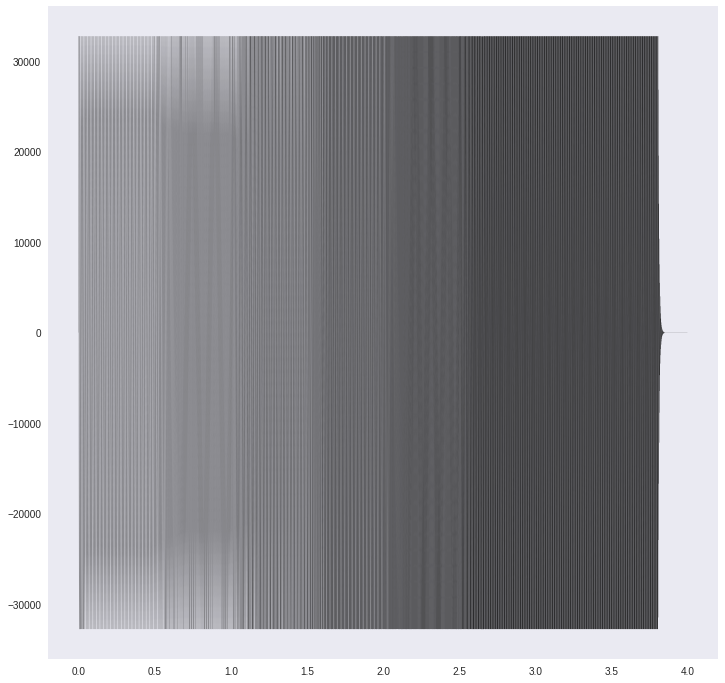

In [71]:
from scipy.io import wavfile
rate, x = wavfile.read('malkauns.wav')
signal = x
# left_channel  = x[:, 0]
# right_channel = x[:, 1]
# signal = left_channel
# signal = (left_channel + right_channel) / 2 # average left and right channels to mono signal // reaaly bad, don't do this
N = len(signal)
t = np.linspace(0, N/rate, N)
plt.grid()
plt.plot(t, signal, 'k-', linewidth=0.1)

In [87]:
nperseg  = 11025//2
noverlap = nperseg // 100 * 92
step = nperseg - noverlap
f_N = nperseg // 1
spectrogram = np.empty( ((signal.shape[-1] - noverlap) // step, f_N) )
t_chunk = np.linspace(0, nperseg / rate, nperseg)
f       = np.geomspace(30, nperseg//2, f_N) # second arg: nperseg//2 (Nyquist limit)


T_chunk, F_chunk = np.meshgrid(t_chunk, f)
E = np.exp(-2j * np.pi * F_chunk * T_chunk)

j = 0
for i in range(0, N, step):
    if j % 20 == 0:
      print(f'{j + 1}/{spectrogram.shape[0]}', end=' ')
    if(j % 100 == 0):
#     if j % 15 == 0:
      print('\n', end='')
    chunk = signal[i : i + nperseg]
    
    if E.shape[1] == chunk.shape[0]:
#         print(chunk.shape, np.hanning(nperseg).shape)
#         chunk = chunk * np.hamming(nperseg)
#         chunk = chunk * np.bartlett(nperseg)
        chunk = chunk * np.blackman(nperseg)
        corr = E @ chunk
        
        magnitude = np.abs(corr)
        
#         magnitude = magnitude * np.geomspace(1, 10000, f_N) # high freqs saturation
  
        maximas_mask = np.r_[True, magnitude[1:] > magnitude[:-1]] & np.r_[magnitude[:-1] > magnitude[1:], True]

        sharp_peaks = np.zeros_like(magnitude)
        sharp_peaks[maximas_mask] = magnitude[maximas_mask]
        
        sharp_peaks[sharp_peaks < np.max(sharp_peaks) / 2] = 0 # filter out small maximas
#         sharp_peaks[maximas_mask] = 1
  
    
#         print(spectrogram.shape, magnitude.shape)
#         spectrogram[j] = magnitude
        spectrogram[j] = sharp_peaks
        j += 1

1/379 
21/379 41/379 61/379 81/379 101/379 
121/379 141/379 161/379 181/379 201/379 
221/379 241/379 261/379 281/379 301/379 
321/379 341/379 361/379 

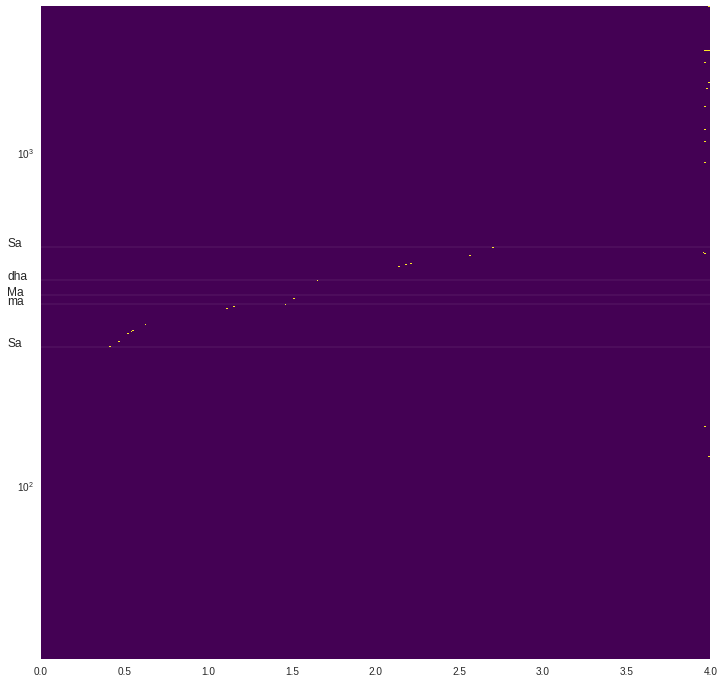

In [93]:
t_for_spectrogram = np.linspace(0, N/rate, j)
T, F = np.meshgrid(t_for_spectrogram, f)

# spec_filtered = np.copy(spectrogram.T)
spec_filtered = np.clip(spectrogram.T, 0, 1)
# spec_filtered = 20 * np.log10(spec_filtered.T)
# print(T.shape, F.shape, spec_filtered.shape)
# spec_filtered[spec_filtered < 2000000] = 0

plt.pcolormesh(T, F, spec_filtered, cmap='viridis')

freqlines = np.array([261, 350, 372, 415, 522])
plt.semilogy()
plt.hlines(freqlines, xmin=0, xmax=N/rate, linewidth=0.1, color='w', label='Sa')
plt.text(-0.2, 261, 'Sa', fontsize=12)
plt.text(-0.2, 350, 'ma', fontsize=12)
plt.text(-0.2, 372, 'Ma', fontsize=12)
plt.text(-0.2, 415, 'dha', fontsize=12)
plt.text(-0.2, 522, 'Sa', fontsize=12)
# plt.hlines(f, xmin=0, xmax=400, linewidth=1, color='w')
# plt.axhline(y=261, linewidth=1, color='w')
plt.grid(False)
plt.show()

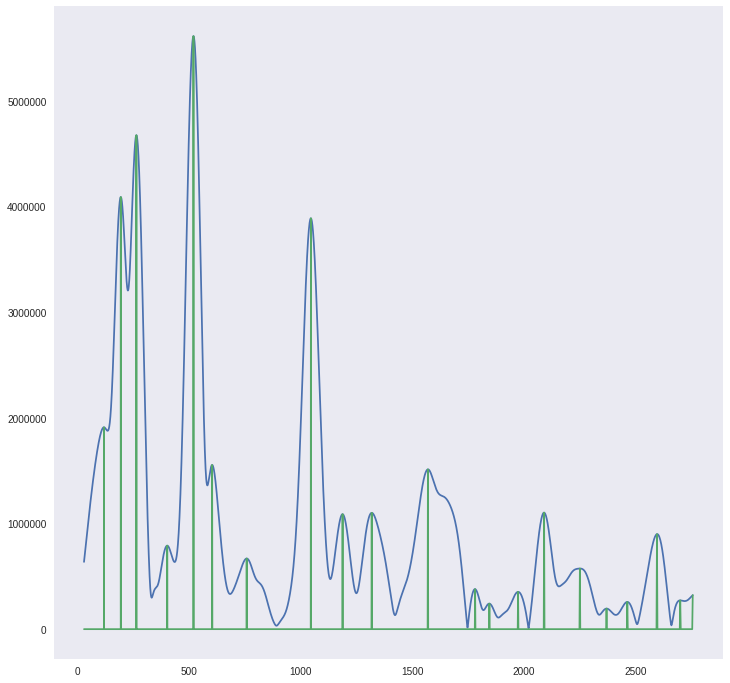

In [63]:
a = spectrogram[123]

# stackoverflow.com/a/4625132/4204843
# z = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True] # minimas
z = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True] # maximas

gg = np.zeros(len(a))
gg[z] = a[z]
plt.plot(f, spectrogram[123])
plt.plot(f, gg)
plt.grid(False)

In [62]:
cc = np.array([0, 1, 2, 3, 4, 2, 1, 2, 4, 7 ,8, 7, 1])
nn = len(cc)
zz = np.r_[True, cc[1:] > cc[:-1]] & np.r_[cc[:-1] > cc[1:], True] # maximas
print(zz)
gg = np.zeros(nn)

gg[zz] = cc[zz]
gg
# cc[zz]

[False False False False  True False False False False False  True False
 False]


array([0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 8., 0., 0.])

In [0]:
f = np.linspace(0, N//4, N*2)
T, F = np.meshgrid(t, f)
E = np.exp(-2j * np.pi * F * T)

corr = E @ signal
# magnitude = 20 * np.log10(np.abs(corr))
magnitude = np.abs(corr)

# slic = 100

# plt.plot(f[:slic], magnitude[:slic])
plt.plot(f, magnitude)

# corr.shape
# corr

In [0]:
x = np.arange(8)
x
nperseg  = 3
noverlap = 2
step = nperseg - noverlap

((x.shape[-1] - noverlap) // step, nperseg)
# x.shape
# x.shape[-1] 

(6, 3)

In [34]:
x = np.arange(10)
x.sort()
x[-2]

8